<a href="https://colab.research.google.com/github/dhnam/cgan_hai/blob/main/cgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

주어진 gan.ipynb의 내용을 참고, cgan을 만들어봄.

cgan은 conditional gan의 약자로, 생성 내용을 어느 정도 control할 수 있게 함.

In [1]:
!pip install torch torchvision numpy matplotlib

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# MNIST 데이터셋 불러오기

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# MNIST 데이터셋을 다운로드 & dataloader 생성
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 11565498.34it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 344481.93it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 2725229.57it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 10336694.94it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



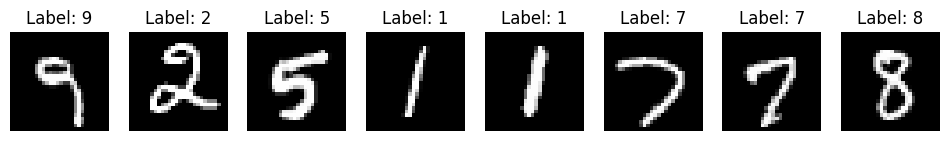

In [34]:
# 이미지 여러 장 출력하는 함수
def show_images(images, labels):
    images = images / 2 + 0.5 # 이미지를 출력할 수 있게 -1 ~ 1 사이의 값으로 변환
    npimg = images.numpy() # 이미지를 numpy 배열로 변환
    fig, axes = plt.subplots(1, 8, figsize=(12, 12))

    # 이미지 출력
    for i in range(8):
        ax = axes[i]
        ax.imshow(npimg[i].reshape(28, 28), cmap='gray')
        ax.set_title(f'Label: {labels[i].item()}')
        ax.axis('off')
    plt.show()

# 이미지 배치를 불러옴
dataiter = iter(dataloader)
images, labels = next(dataiter)

show_images(images, labels)

Label 정보를 이용할 것이다.

Label은 one-hot을 이용할 것이고, generator의 100차원/discriminator의 784차원 입력에 추가될 것이다.

In [8]:
# one-hot encoding example
labels_onehot = torch.eye(10)[labels]

concat할 때 ,T를 하는 이유

shape가 각각 (64, 10)과 (64, 784) (혹은 (64, 100))인데,

dimension 0을 제외한 다른 차원이 크기가 같아야 concat을 해줄 수 있다.

그렇기 때문에 먼저 Transpose를 해줘서 (10, 64)와 (*, 64)로 만들어준 후,

concat후 다시 Transpose해준다.

In [22]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.ReLU(),
            nn.Linear(784, output_dim),
            nn.Tanh()
        )

    def forward(self, x, label):
        # simple concat label with x(noise)
        concat_input = torch.concat([x.T, label.T]).T
        return self.model(concat_input)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 784),
            nn.ReLU(),
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x, label):
        # simple concat label with x(image)
        concat_input = torch.concat([x.T, label.T]).T
        return self.model(concat_input)

In [23]:
latent_dim = 100
img_shape = 28 * 28
label_size = 10

generator = Generator(input_dim=latent_dim+label_size, output_dim=img_shape)
discriminator = Discriminator(input_dim=img_shape+label_size)

lr = 0.0002
b1 = 0.5
b2 = 0.999

optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

adversarial_loss = nn.BCELoss()

Epoch [0/50] Batch 0/938                   Loss D: 0.21610493957996368, loss G: 1.7377755641937256
Epoch [0/50] Batch 400/938                   Loss D: 0.21923919022083282, loss G: 2.519937038421631
Epoch [0/50] Batch 800/938                   Loss D: 0.08154211193323135, loss G: 3.44020676612854


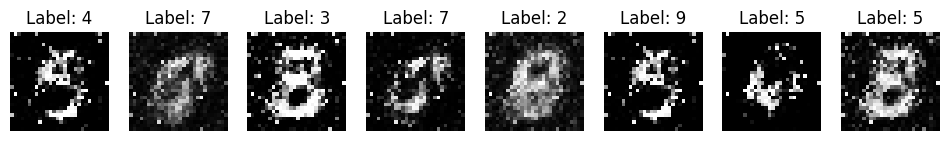

Epoch [1/50] Batch 0/938                   Loss D: 0.11924555152654648, loss G: 2.9076642990112305
Epoch [1/50] Batch 400/938                   Loss D: 0.17675592005252838, loss G: 3.4121785163879395
Epoch [1/50] Batch 800/938                   Loss D: 0.1643250286579132, loss G: 2.325713634490967
Epoch [2/50] Batch 0/938                   Loss D: 0.42349016666412354, loss G: 1.3746076822280884
Epoch [2/50] Batch 400/938                   Loss D: 0.16103360056877136, loss G: 3.1188204288482666
Epoch [2/50] Batch 800/938                   Loss D: 0.44736984372138977, loss G: 3.799074649810791
Epoch [3/50] Batch 0/938                   Loss D: 0.2430850863456726, loss G: 1.7904441356658936
Epoch [3/50] Batch 400/938                   Loss D: 0.24149900674819946, loss G: 2.284146785736084
Epoch [3/50] Batch 800/938                   Loss D: 0.26109668612480164, loss G: 2.0705008506774902
Epoch [4/50] Batch 0/938                   Loss D: 0.3101311922073364, loss G: 1.485854148864746
Epoch

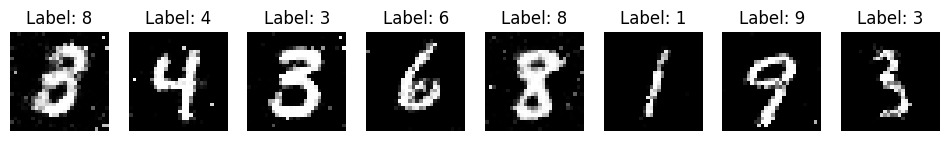

Epoch [11/50] Batch 0/938                   Loss D: 0.5012123584747314, loss G: 1.2021775245666504
Epoch [11/50] Batch 400/938                   Loss D: 0.40851715207099915, loss G: 1.7917613983154297
Epoch [11/50] Batch 800/938                   Loss D: 0.38966524600982666, loss G: 1.456538200378418
Epoch [12/50] Batch 0/938                   Loss D: 0.4419647753238678, loss G: 1.2309095859527588
Epoch [12/50] Batch 400/938                   Loss D: 0.4657435417175293, loss G: 1.6461091041564941
Epoch [12/50] Batch 800/938                   Loss D: 0.48503807187080383, loss G: 1.3473423719406128
Epoch [13/50] Batch 0/938                   Loss D: 0.5337267518043518, loss G: 1.5181154012680054
Epoch [13/50] Batch 400/938                   Loss D: 0.42075276374816895, loss G: 1.7555651664733887
Epoch [13/50] Batch 800/938                   Loss D: 0.41542619466781616, loss G: 1.769393801689148
Epoch [14/50] Batch 0/938                   Loss D: 0.4394242465496063, loss G: 1.443917274475

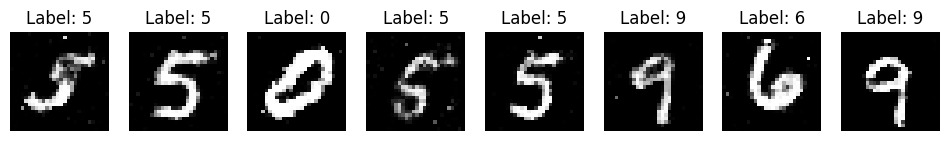

Epoch [21/50] Batch 0/938                   Loss D: 0.43924686312675476, loss G: 1.3688175678253174
Epoch [21/50] Batch 400/938                   Loss D: 0.4543207585811615, loss G: 1.5077221393585205
Epoch [21/50] Batch 800/938                   Loss D: 0.5253915786743164, loss G: 1.3490347862243652
Epoch [22/50] Batch 0/938                   Loss D: 0.5504094958305359, loss G: 1.440573811531067
Epoch [22/50] Batch 400/938                   Loss D: 0.49904972314834595, loss G: 1.5752626657485962
Epoch [22/50] Batch 800/938                   Loss D: 0.4766864776611328, loss G: 1.1984729766845703
Epoch [23/50] Batch 0/938                   Loss D: 0.39548200368881226, loss G: 1.4730364084243774
Epoch [23/50] Batch 400/938                   Loss D: 0.533547043800354, loss G: 1.5241742134094238
Epoch [23/50] Batch 800/938                   Loss D: 0.5050738453865051, loss G: 1.0532881021499634
Epoch [24/50] Batch 0/938                   Loss D: 0.6095407009124756, loss G: 0.73748260736465

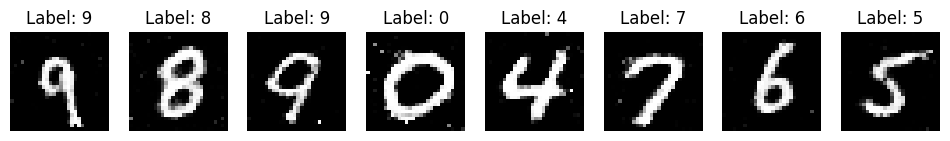

Epoch [31/50] Batch 0/938                   Loss D: 0.535510241985321, loss G: 1.0335079431533813
Epoch [31/50] Batch 400/938                   Loss D: 0.4571417272090912, loss G: 1.6840665340423584
Epoch [31/50] Batch 800/938                   Loss D: 0.5127164125442505, loss G: 1.6310700178146362
Epoch [32/50] Batch 0/938                   Loss D: 0.3992805480957031, loss G: 1.5674943923950195
Epoch [32/50] Batch 400/938                   Loss D: 0.47657373547554016, loss G: 1.4938398599624634
Epoch [32/50] Batch 800/938                   Loss D: 0.4651215076446533, loss G: 1.081364631652832
Epoch [33/50] Batch 0/938                   Loss D: 0.48911768198013306, loss G: 1.5926024913787842
Epoch [33/50] Batch 400/938                   Loss D: 0.4602155089378357, loss G: 1.2359743118286133
Epoch [33/50] Batch 800/938                   Loss D: 0.518949031829834, loss G: 1.4490668773651123
Epoch [34/50] Batch 0/938                   Loss D: 0.43275243043899536, loss G: 1.509886026382446

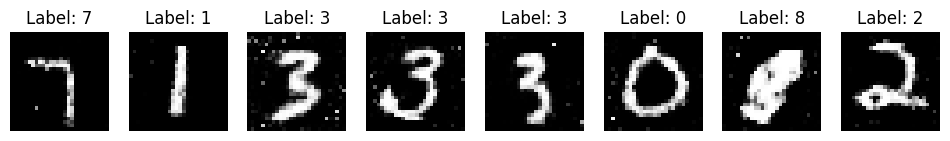

Epoch [41/50] Batch 0/938                   Loss D: 0.442429780960083, loss G: 1.4323656558990479
Epoch [41/50] Batch 400/938                   Loss D: 0.47793108224868774, loss G: 1.475430965423584
Epoch [41/50] Batch 800/938                   Loss D: 0.46972569823265076, loss G: 1.4408798217773438
Epoch [42/50] Batch 0/938                   Loss D: 0.3754025101661682, loss G: 1.4274766445159912
Epoch [42/50] Batch 400/938                   Loss D: 0.43987056612968445, loss G: 1.484706163406372
Epoch [42/50] Batch 800/938                   Loss D: 0.4611096978187561, loss G: 1.721626877784729
Epoch [43/50] Batch 0/938                   Loss D: 0.5078613758087158, loss G: 1.1258113384246826
Epoch [43/50] Batch 400/938                   Loss D: 0.3948323130607605, loss G: 1.6286163330078125
Epoch [43/50] Batch 800/938                   Loss D: 0.5369933843612671, loss G: 1.1025211811065674
Epoch [44/50] Batch 0/938                   Loss D: 0.47528839111328125, loss G: 1.330829620361328

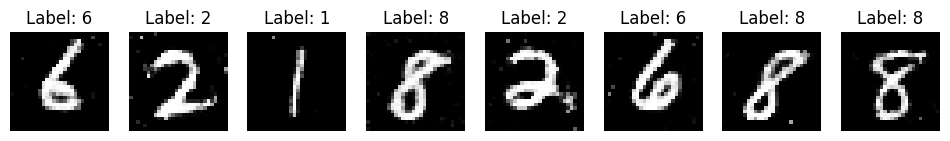

In [30]:
num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator.to(device)
discriminator.to(device)
adversarial_loss.to(device)

for epoch in range(num_epochs):
    for i, (imgs, labels) in enumerate(dataloader):
        # label을 먼저 onehot 인코딩
        labels_onehot = torch.eye(10)[labels].to(device)

        # 진짠지 가짠지에 대한 레이블 생성
        valid = torch.ones((imgs.size(0), 1), requires_grad=False).to(device)
        fake = torch.zeros((imgs.size(0), 1), requires_grad=False).to(device)

        # 진짜 이미지 (데이터셋에서 불러온거)
        real_imgs = imgs.view(imgs.size(0), -1).to(device)


        ### 생성기 학습
        optimizer_G.zero_grad()

        # 랜덤 노이즈로부터 이미지 생성
        z = torch.randn((imgs.size(0), latent_dim)).to(device)
        gen_imgs = generator(z, labels_onehot)

        # 생성된 이미지를 판별자에 넣어서 결과 확인
        g_loss = adversarial_loss(discriminator(gen_imgs, labels_onehot), valid)
        g_loss.backward()
        optimizer_G.step()


        ### 판별기 학습
        optimizer_D.zero_grad()

        # 진짜 이미지 판별
        real_loss = adversarial_loss(discriminator(real_imgs, labels_onehot), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach(), labels_onehot), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        if i % 400 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch {i}/{len(dataloader)} \
                  Loss D: {d_loss.item()}, loss G: {g_loss.item()}")

    # 중간 단계 확인을 위해 생성된 이미지 저장
    if epoch % 10 == 0:
        gen_imgs = gen_imgs.view(gen_imgs.size(0), 1, 28, 28)
        show_images(gen_imgs.data[:8].cpu(), labels[:8].cpu())
        with open(f"images/{epoch}.png", "wb") as f:
            save_image(gen_imgs.data[:25], f, nrow=5, normalize=True)


gen_imgs = gen_imgs.view(gen_imgs.size(0), 1, 28, 28)
show_images(gen_imgs.data[:8].cpu(), labels[:8].cpu())
with open(f"images/final.png", "wb") as f:
    save_image(gen_imgs.data[:25], f, nrow=5, normalize=True)


개인적인 경험으로 기존 gan에 비해 (다른 것 수정한 것 없이 condition 부분만 추가함)

학습 속도가 훨씬 빠르고 (0번 epoch에 이미 어느 정도 숫자의 형태를 갖춤/10번 epoch에 깔끔한 숫자가 보임)

숫자의 생성이 훨씬 균일하다. (기존 gan은 1, 7, 9 등의 직선이 두드러지는 숫자를 더 자주 생성함.)

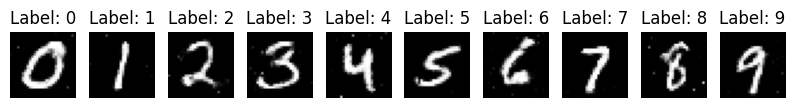

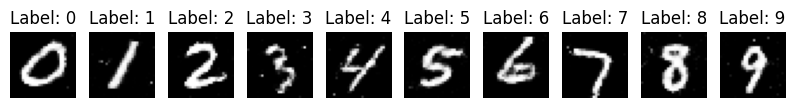

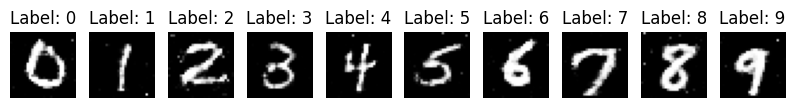

In [35]:
def show_generated_imgs(generator, latent_dim, numbers, num_images=5):
    assert len(numbers) == num_images
    z = torch.randn(num_images, latent_dim).to(device)
    one_hot = torch.eye(10)[numbers].to(device)
    gen_imgs = generator(z, one_hot)
    gen_imgs = gen_imgs.view(gen_imgs.size(0), 1, 28, 28)
    gen_imgs = gen_imgs.detach().cpu().numpy()

    fig, axes = plt.subplots(1, num_images, figsize=(num_images, 1))
    for i in range(num_images):
        axes[i].imshow(np.transpose(gen_imgs[i], (1, 2, 0)).squeeze(), cmap='gray')
        axes[i].set_title(f"Label: {numbers[i]}")
        axes[i].axis('off')
    plt.show()

gen_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
show_generated_imgs(generator, latent_dim, gen_labels, 10)
show_generated_imgs(generator, latent_dim, gen_labels, 10)
show_generated_imgs(generator, latent_dim, gen_labels, 10)